# Initialization

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

In [2]:
from algorithms import ChainTopology, RingTopology, QuadraticsTask, relaysum_model, relaysum_grad, relaysum_mix, all_reduce, gossip, d2, gradient_tracking, BinaryTreeTopology, relaysum_grad_overlap, relaysgd, pushsum, time_varying_sgp, one_way_path_averaging

In [3]:
from random_quadratics import RandomQuadraticsTask

In [4]:
import torch
import math
import tuning
import pandas as pd
from warehouse import Warehouse

tree = BinaryTreeTopology

In [5]:
torch.set_default_dtype(torch.float64)

# All - Chain topology

In [23]:
num_workers = 32
d = 10
# noise = 0.5
noise = 0
mu = 0.5
zetas = [0, .01, 1]
max_steps = [200, 500, 2000]
eval_intervals = [2, 5, 20]
plateau = 1e-6
seed = 0
warehouse = Warehouse()
algorithm_name = "Gossip"
algorithm = gossip
# topology_name = "ring"
# topology = RingTopology(num_workers)
topology_name = "chain"
topology = ChainTopology(num_workers)
warehouse.clear("error", {"algorithm": algorithm_name})
for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000)
    print(f"learning rate is {learning_rate}")
    if learning_rate is None:
        continue
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    print("warehouse.clear(\"error\", tags)")
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
learning rate is 1.25
warehouse.clear("error", tags)
5.792939955034237e-13
Tuning for 0.01
learning rate is 0.0439453125
warehouse.clear("error", tags)
8.518613525757002e-07
Tuning for 1
learning rate is 0.0008392333984375
warehouse.clear("error", tags)
0.08293786081154209


In [24]:
algorithm_name = "RelaySGD/OneNode"
algorithm = relaysgd
topology_name = "chain"
topology = ChainTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000)
    if learning_rate is None:
        continue
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            # if error < 1e-12:
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
8.891940756770706e-13
Tuning for 0.01
6.231890004038121e-13
Tuning for 1
2.646771690706373e-13


In [25]:
algorithm_name = "RelaySGD/Grad"
algorithm = relaysum_grad
topology_name = "chain"
topology = ChainTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000)
    if learning_rate is None:
        continue
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
7.337735926384553e-11
Tuning for 0.01
2.0265183017786903e-08
Tuning for 1
8.653164309535555e-07


In [26]:
algorithm_name = "RelaySGD"
algorithm = relaysum_model
topology_name = "chain"
topology = ChainTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    eval_interval = 1
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_fastest(start_lr=10, target_quality=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=10000, num_test_points=1000)
    print(steps, learning_rate)
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

51 0.869140625
5.317038806265014e-10
51 0.869140625
9.848788451449764e-13
50 0.8837890625
9.592326932761353e-13


In [27]:
algorithm_name = "SGP"
algorithm = time_varying_sgp
# topology_name = "ring"
# topology = RingTopology(num_workers)
# topology = tree(num_workers)
topology_name = "chain"
topology = ChainTopology(num_workers)
eps = 1e-6
warehouse.clear("error", {"algorithm": algorithm_name})
for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    print("Task created")
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000) 
    # best_time, best_lr = tuning.tune_fastest(start_lr=10, target_quality=eps, task=task, algorithm=algorithm, topology=topology, max_steps=20000, num_test_points=1000)
    print(f"The found learning rate = {learning_rate}")

    if learning_rate is None:
        # continue
        steps = 50
        learning_rate = 0.5
        print("Learning rate not found, using learning_rate = {learning_rate}")
    
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    print("warehouse.clear(\"error\", tags)")
    warehouse.clear("error", tags)
    errors = {}
    k = 0 
    print(f"Training started with steps {steps} and learning rate {learning_rate}")
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        # print(f"The step is at {iterate.step}")
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item()
            errors[iterate.step] = error
            if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
                print("no improvement after", iterate.step)
                break
            if error < 1e-12:
                break
            if k > 50:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
        # print("Iteration ends")
        # if iterate.step > 50:
        #     break
    print(f"The error is {error}")

Tuning for 0
Task created
The found learning rate = 2.5
warehouse.clear("error", tags)
Training started with steps 29 and learning rate 2.5
no improvement after 42
The error is 3.5136987831112204e-12
Tuning for 0.01
Task created
The found learning rate = 0.234375
warehouse.clear("error", tags)
Training started with steps 64 and learning rate 0.234375
no improvement after 100
The error is 9.181585866758352e-07
Tuning for 1
Task created
The found learning rate = 0.01708984375
warehouse.clear("error", tags)
Training started with steps 889 and learning rate 0.01708984375
no improvement after 900
The error is 9.556455689008203e-07


## ompa

In [21]:
num_workers = 32
d = 10
# noise = 0.5
noise = 0
mu = 0.5
zetas = [0, .01 , 1]
max_steps = [200, 5000, 8000]
eval_intervals = [10, 500, 500]
plateau = 1e-6
seed = 0
num_communication_rounds = 16 
warehouse = Warehouse()
algorithm_name = "OWPA"
algorithm = one_way_path_averaging
# topology_name = "ring"
# topology = RingTopology(num_workers)
topology_name = "chain"
topology = ChainTopology(num_workers)
warehouse.clear("error", {"algorithm": algorithm_name})
for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    if zeta2 == 0: 
        tuning_steps = 1000
    else: 
        tuning_steps = 100
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=tuning_steps, num_test_points=1000)
    if learning_rate is None:
        if zeta2 == 0.01:
            learning_rate = 0.005 
        elif zeta2 == 1: 
            learning_rate = 0.005 
        print(f"didn't find a learning rate, using {learning_rate}")
    else:
        print(f"the found learning rate is {learning_rate}")
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    print("warehouse.clear(\"error\", tags)")
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
            print(f"The error is {error}")
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
the found learning rate is 1.25
warehouse.clear("error", tags)
The error is 0.592253522456097
The error is 3.257256622655124e-09
The error is 1.1284235750468773e-12
The error is 6.684408168748448e-16
6.684408168748448e-16
Tuning for 0.01
didn't find a learning rate, using 0.005
warehouse.clear("error", tags)
The error is 0.592253522456097
The error is 0.031060029598383852
The error is 0.0017533587318386834
The error is 0.00012211275171279332
The error is 1.3553380567434686e-05
The error is 1.2926936129687566e-05
The error is 1.4364373496684318e-05
The error is 1.126631491504132e-05
The error is 8.771587292438071e-06
The error is 8.51754617112177e-06
8.51754617112177e-06
Tuning for 1
didn't find a learning rate, using 0.005
warehouse.clear("error", tags)
The error is 0.592253522456097
The error is 0.031202491869460225
The error is 0.002713720942147946
The error is 0.001454039459055867
The error is 0.0011303501115174086
The error is 0.0013821205502817513
The error is 0.00074

KeyboardInterrupt: 

## plotting

/home/ziwliu/relaysgd/paper-figures
The learning rate is 0.01708984375, the topology is chain


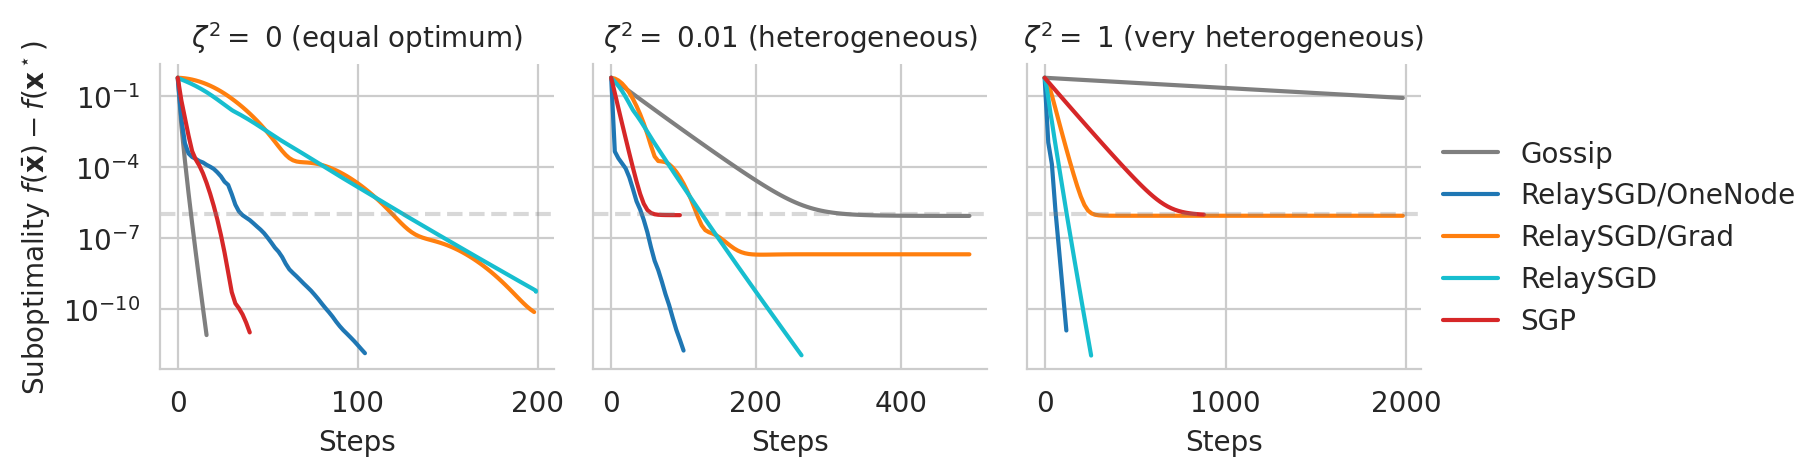

In [28]:
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
import matplotlib

colors = [sns.color_palette("tab10")[i] for i in [7, 0, 1, 9, 3]]
sns.set_palette(colors)

df = warehouse.query("error")
df["zeta2name"] = df["zeta2"].replace({0: "0 (equal optimum)", .01: "0.01 (heterogeneous)", 1: "1 (very heterogeneous)"})
df["algoname"] = df.algorithm.replace({"D2": r"$\text{D}^2$", "RelaySum/Model": "RelaySGD"})
import os
print(os.getcwd())
g = sns.FacetGrid(hue="algoname", col="zeta2name", data = df, height=2.5, sharex=False)
g.map(plt.plot, "step", "value")

for ax in g.axes[0]:
    ax.axhline(1e-6, ls='--', c='gray', alpha=0.3)

g.set_titles(r"$\zeta^2 =$ {col_name}")
g.set(yscale="log");
# g.set_ylabels(r"Mean sq. distance to optimum")
g.set_ylabels(r"Suboptimality $f(\bar{\mathbf{x}}) - f(\mathbf{x}^\star)$")
g.set(xlabel="Steps")
g.tight_layout()
# g.set(ylim=[1e-9, 1])
g.add_legend(title="")
print(f"The learning rate is {learning_rate}, the topology is {topology_name}")
plt.show(g)

# OWPA - Tree

In [26]:
num_workers = 32
d = 10
# noise = 0.5
noise = 0
mu = 0.5
zetas = [0, .01, 1]
max_steps = [2000, 40000, 60000]
eval_intervals = [2, 5, 20]
plateau = 1e-6
seed = 0
warehouse = Warehouse()
algorithm_name = "OWPA"
algorithm = one_way_path_averaging
topology_name = "tree"
topology = tree(num_workers)
eps = 1e-6
warehouse.clear("error", {"algorithm": algorithm_name})
for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    print("Task created")
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=100, num_test_points=1000)

    if learning_rate is None:
        # continue
        steps = 50
        learning_rate = 0.0005
        print("Learning rate not found, using learning_rate = {learning_rate}")
    else: 
        print(f"The found learning rate = {learning_rate}")
        
    
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    print("warehouse.clear(\"error\", tags)")
    warehouse.clear("error", tags)
    errors = {}
    k = 0 
    print(f"Training started with steps {steps} and learning rate {learning_rate}")
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        # print(f"The step is at {iterate.step}")
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item()
            errors[iterate.step] = error
            if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
                print("no improvement after", iterate.step)
                break
            if error < 1e-12:
                break
            if k > 50:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
        # print("Iteration ends")
        # if iterate.step > 50:
        #     break
    print(f"The error is {error}")

Tuning for 0
Task created
The found learning rate = 1.484375
warehouse.clear("error", tags)
Training started with steps 13 and learning rate 1.484375
The error is 1.3761835061967834e-13
Tuning for 0.01
Task created
The found learning rate = None
Learning rate not found, using learning_rate = {learning_rate}
warehouse.clear("error", tags)
Training started with steps 50 and learning rate 0.0005
no improvement after 16050
The error is 4.721877697531213e-05
Tuning for 1
Task created
The found learning rate = None
Learning rate not found, using learning_rate = {learning_rate}
warehouse.clear("error", tags)
Training started with steps 50 and learning rate 0.0005
no improvement after 13700
The error is 0.0003674488372709117


/home/ziwliu/relaysgd/paper-figures


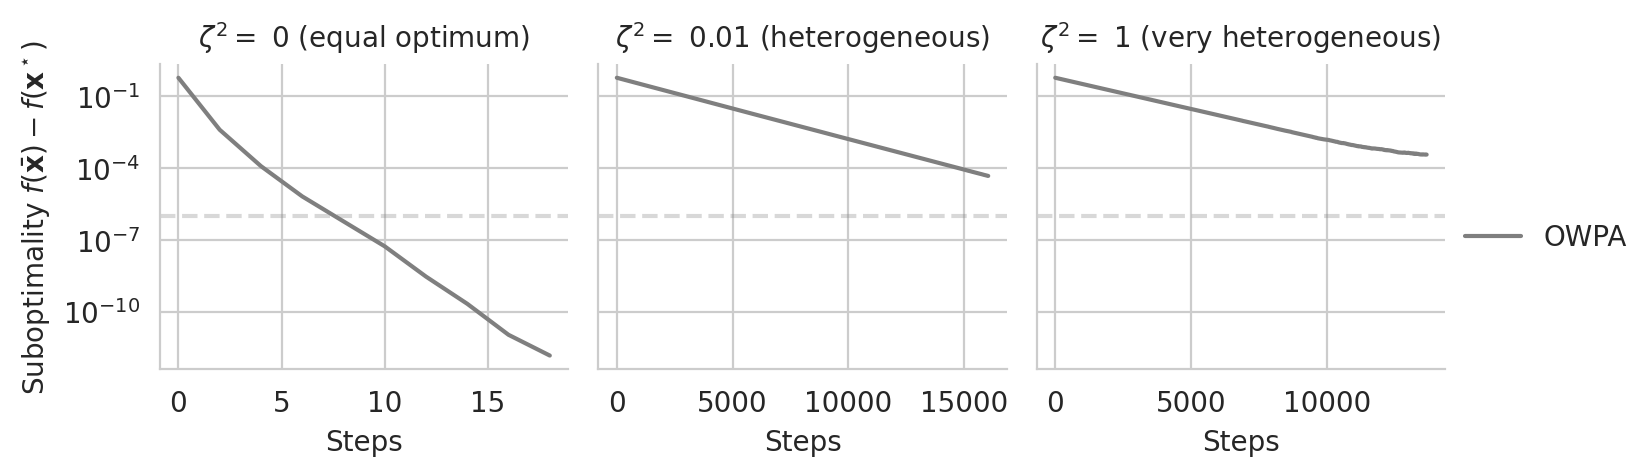

In [28]:
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Times"],
#     'text.latex.preamble' : r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{newtxmath}'
# })

colors = [sns.color_palette("tab10")[i] for i in [7, 0, 1, 9, 3]]
sns.set_palette(colors)

df = warehouse.query("error")
df["zeta2name"] = df["zeta2"].replace({0: "0 (equal optimum)", .01: "0.01 (heterogeneous)", 1: "1 (very heterogeneous)"})
# df["algoname"] = df.algorithm.replace({"D2": r"$\text{D}^2$", "RelaySum/Model": "RelaySGD"})
df["algoname"] = df.algorithm.replace({"D2": r"$\text{D}^2$", "SGP": "OWPA"})
import os
print(os.getcwd())
g = sns.FacetGrid(hue="algoname", col="zeta2name", data = df, height=2.5, sharex=False)
g.map(plt.plot, "step", "value")

for ax in g.axes[0]:
    ax.axhline(1e-6, ls='--', c='gray', alpha=0.3)

g.set_titles(r"$\zeta^2 =$ {col_name}")
g.set(yscale="log");
# g.set_ylabels(r"Mean sq. distance to optimum")
g.set_ylabels(r"Suboptimality $f(\bar{\mathbf{x}}) - f(\mathbf{x}^\star)$")
g.set(xlabel="Steps")
g.tight_layout()
# g.set(ylim=[1e-9, 1])
g.add_legend(title="")
plt.show(g)

In [ ]:
g.savefig("model_vs_grad_curves.pdf", bbox_inches="tight")

# All - Tree

## Other topologies

In [ ]:
num_workers = 32
d = 10
# noise = 0.5
noise = 0
mu = 0.5
zetas = [0, .01, 1]
max_steps = [200, 500, 2000]
eval_intervals = [2, 5, 20]
plateau = 1e-6
seed = 0
warehouse = Warehouse()
algorithm_name = "Gossip"
algorithm = gossip
topology_name = "tree"
topology = tree(num_workers)
warehouse.clear("error", {"algorithm": algorithm_name})
for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000)
    print(f"learning rate is {learning_rate}")
    if learning_rate is None:
        continue
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    print("warehouse.clear(\"error\", tags)")
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
learning rate is 1.25
warehouse.clear("error", tags)
5.792939955034237e-13
Tuning for 0.01
learning rate is 0.0439453125
warehouse.clear("error", tags)
8.518613525757002e-07
Tuning for 1
learning rate is 0.0008392333984375
warehouse.clear("error", tags)
0.08293786081154209


In [ ]:
algorithm_name = "RelaySGD/OneNode"
algorithm = relaysgd
topology_name = "tree"
topology = tree(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000)
    if learning_rate is None:
        continue
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            # if error < 1e-12:
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
8.891940756770706e-13
Tuning for 0.01
6.231890004038121e-13
Tuning for 1
2.646771690706373e-13


In [ ]:
algorithm_name = "RelaySGD/Grad"
algorithm = relaysum_grad
topology_name = "tree"
topology = tree(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000)
    if learning_rate is None:
        continue
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
7.337735926384553e-11
Tuning for 0.01
2.0265183017786903e-08
Tuning for 1
8.653164309535555e-07


In [ ]:
algorithm_name = "RelaySGD"
algorithm = relaysum_model
topology_name = "tree"
topology = tree(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    eval_interval = 1
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_fastest(start_lr=10, target_quality=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=10000, num_test_points=1000)
    print(steps, learning_rate)
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

51 0.869140625
5.317038806265014e-10
51 0.869140625
9.848788451449764e-13
50 0.8837890625
9.592326932761353e-13


In [ ]:
algorithm_name = "SGP"
algorithm = time_varying_sgp
topology_name = "tree"
topology = tree(num_workers)
eps = 1e-6
warehouse.clear("error", {"algorithm": algorithm_name})
for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    print("Task created")
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000) 
    # best_time, best_lr = tuning.tune_fastest(start_lr=10, target_quality=eps, task=task, algorithm=algorithm, topology=topology, max_steps=20000, num_test_points=1000)
    print(f"The found learning rate = {learning_rate}")

    if learning_rate is None:
        # continue
        steps = 50
        learning_rate = 0.5
        print("Learning rate not found, using learning_rate = {learning_rate}")
    
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    print("warehouse.clear(\"error\", tags)")
    warehouse.clear("error", tags)
    errors = {}
    k = 0 
    print(f"Training started with steps {steps} and learning rate {learning_rate}")
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        # print(f"The step is at {iterate.step}")
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item()
            errors[iterate.step] = error
            if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
                print("no improvement after", iterate.step)
                break
            if error < 1e-12:
                break
            if k > 50:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
        # print("Iteration ends")
        # if iterate.step > 50:
        #     break
    print(f"The error is {error}")

Tuning for 0
Task created
The found learning rate = 2.5
warehouse.clear("error", tags)
Training started with steps 29 and learning rate 2.5
no improvement after 42
The error is 3.5136987831112204e-12
Tuning for 0.01
Task created
The found learning rate = 0.234375
warehouse.clear("error", tags)
Training started with steps 64 and learning rate 0.234375
no improvement after 100
The error is 9.181585866758352e-07
Tuning for 1
Task created
The found learning rate = 0.01708984375
warehouse.clear("error", tags)
Training started with steps 889 and learning rate 0.01708984375
no improvement after 900
The error is 9.556455689008203e-07


## ompa

In [8]:
num_workers = 32
d = 10
# noise = 0.5
noise = 0
mu = 0.5
zetas = [0, .01 , 1]
max_steps = [200, 20000, 20000]
eval_intervals = [10, 500, 500]
plateau = 1e-6
seed = 0
num_communication_rounds = 16 
warehouse = Warehouse()
algorithm_name = "OWPA"
algorithm = one_way_path_averaging
topology_name = "tree"
topology = tree(num_workers)
warehouse.clear("error", {"algorithm": algorithm_name})
for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    if zeta2 == 0: 
        tuning_steps = 1000
    else: 
        tuning_steps = 100
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=tuning_steps, num_test_points=1000)
    if learning_rate is None:
        if zeta2 == 0.01:
            learning_rate = 0.0005 
        elif zeta2 == 1: 
            learning_rate = 0.0005 
        print(f"didn't find a learning rate, using {learning_rate}")
    else:
        print(f"the found learning rate is {learning_rate}")
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    print("warehouse.clear(\"error\", tags)")
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
            print(f"The error is {error}")
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
the found learning rate is 1.484375
warehouse.clear("error", tags)
The error is 0.592253522456097
The error is 6.119308443633192e-08
The error is 1.2026090711294876e-13
1.2026090711294876e-13
Tuning for 0.01
didn't find a learning rate, using 0.0005
warehouse.clear("error", tags)
The error is 0.592253522456097
The error is 0.43979937272285835
The error is 0.3266457936931609
The error is 0.24276017744666445
The error is 0.18044573766130703
The error is 0.13427833146500195
The error is 0.09995648739576707
The error is 0.07440907802270164
The error is 0.055381008416057496
The error is 0.04126581827816338
The error is 0.03076739593699295
The error is 0.02291982539530967
The error is 0.01710078073721548
The error is 0.01275838664810696
The error is 0.009522724634809798
The error is 0.007110564030575733
The error is 0.005308736653133701
The error is 0.003953993797078795
The error is 0.002951231653590229
The error is 0.002201630278713458
The error is 0.0016398842648239834
The err

In [13]:
# waiting to run 
zetas = [.01]
max_steps = [25000]
eval_intervals = [500]
plateau = 1e-6
seed = 0
num_communication_rounds = 16 
algorithm_name = "OWPA"
algorithm = one_way_path_averaging
topology_name = "tree"
topology = tree(num_workers)
algorithm_name = "OWPA"
algorithm = one_way_path_averaging
topology_name = "tree"
topology = tree(num_workers)
for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    if zeta2 == 0: 
        tuning_steps = 1000
    else: 
        tuning_steps = 100
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=tuning_steps, num_test_points=1000)
    if learning_rate is None:
        if zeta2 == 0.01:
            learning_rate = 0.0005 
        elif zeta2 == 1: 
            learning_rate = 0.0005 
        print(f"didn't find a learning rate, using {learning_rate}")
    else:
        print(f"the found learning rate is {learning_rate}")
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    print("warehouse.clear(\"error\", tags)")
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
            print(f"The error is {error}")
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0.01
didn't find a learning rate, using 0.0005
warehouse.clear("error", tags)
The error is 0.592253522456097
The error is 0.4398209371942743
The error is 0.32688685193712896
The error is 0.2429727838944336
The error is 0.1806933228731575
The error is 0.13440576307986665
The error is 0.10000835045172601
The error is 0.07443231624141647
The error is 0.05542913319711667
The error is 0.041303511849643655
The error is 0.030772535958767742
The error is 0.022953309634081646
The error is 0.017113394390544753
The error is 0.012774106570599686
The error is 0.009525968047653259
The error is 0.007114767546341369
The error is 0.0053166386347524505
The error is 0.00396855987126319
The error is 0.00295453149377024
The error is 0.0022064035766097105
The error is 0.001648126266844508
The error is 0.0012275270089437545
The error is 0.0009178703220904492
The error is 0.0006859167470830915
The error is 0.0005121540673148385
The error is 0.0003832871854785192
The error is 0.00028754249385263934


## plotting

/home/ziwliu/relaysgd/paper-figures
The learning rate is 0.0005, the topology is tree


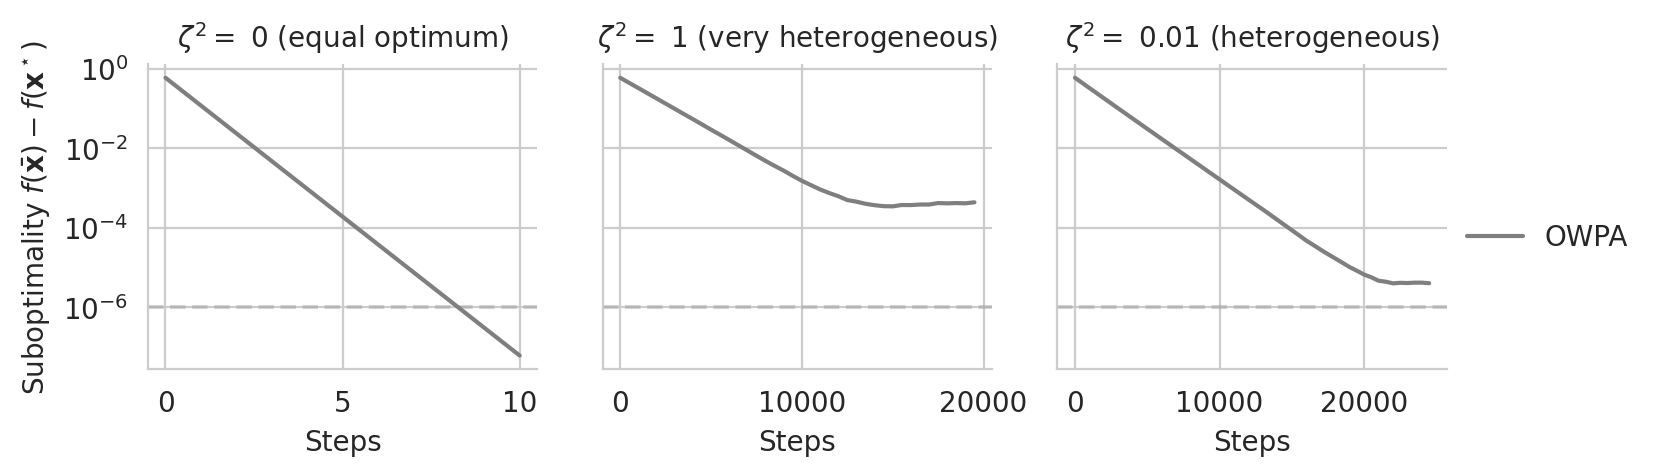

In [14]:
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
import matplotlib

colors = [sns.color_palette("tab10")[i] for i in [7, 0, 1, 9, 3]]
sns.set_palette(colors)

df = warehouse.query("error")
df["zeta2name"] = df["zeta2"].replace({0: "0 (equal optimum)", .01: "0.01 (heterogeneous)", 1: "1 (very heterogeneous)"})
df["algoname"] = df.algorithm.replace({"D2": r"$\text{D}^2$", "RelaySum/Model": "RelaySGD"})
import os
print(os.getcwd())
g = sns.FacetGrid(hue="algoname", col="zeta2name", data = df, height=2.5, sharex=False)
g.map(plt.plot, "step", "value")

for ax in g.axes[0]:
    ax.axhline(1e-6, ls='--', c='gray', alpha=0.3)

g.set_titles(r"$\zeta^2 =$ {col_name}")
g.set(yscale="log");
# g.set_ylabels(r"Mean sq. distance to optimum")
g.set_ylabels(r"Suboptimality $f(\bar{\mathbf{x}}) - f(\mathbf{x}^\star)$")
g.set(xlabel="Steps")
g.tight_layout()
# g.set(ylim=[1e-9, 1])
g.add_legend(title="")
print(f"The learning rate is {learning_rate}, the topology is {topology_name}")
plt.show(g)

# ompa - Ring 

In [ ]:
num_workers = 32
d = 10
# noise = 0.5
noise = 0
mu = 0.5
zetas = [ .01]
max_steps = [4000]

# zetas = [0,  .01, 1]
# zetas = [1]
# max_steps = [200, 2000, 4000]
# max_steps = [3]

eval_intervals = [2, 5, 20]
plateau = 1e-6
seed = 0
warehouse = Warehouse()
algorithm_name = "One-way"
algorithm = one_way_path_averaging
topology = RingTopology(num_workers)
# topology = tree(num_workers)
eps = 1e-6
warehouse.clear("error", {"algorithm": algorithm_name})
for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    print("Task created")
    # if zeta2 == 0: 
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=700, num_test_points=1000) # 
    # steps, learning_rate = tuning.tune_fastest(start_lr=10, target_quality=eps, task=task, algorithm=algorithm, topology=topology, max_steps=200, num_test_points=1000)
    if learning_rate is not None: 
        print(f"The found learning rate = {learning_rate}")
    else: 
        learning_rate = 0.005
    
    print(f"Learning rate not found, using learning_rate = {learning_rate}")
    
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    print("warehouse.clear(\"error\", tags)")
    warehouse.clear("error", tags)
    errors = {}
    k = 0 
    print(f"Training started with steps {steps} and learning rate {learning_rate}")
    for iterate in algorithm(task, topology, learning_rate, num_steps, num_communication_rounds=2):
        # print(f"The step is at {iterate.step}")
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item()
            errors[iterate.step] = error
            if iterate.step % 100 == 0:
                print(f"The error at {iterate.step} is {error}")
            # if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-2:
            #     print("no improvement after", iterate.step)
            #     break
            if error < 1e-12:
                break
            # if k > 50:
            #     break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
        # print("Iteration ends")
        # if iterate.step > 50:
        #     break
    print(f"The error is {error}")

Tuning for 0.01
Task created
Learning rate not found, using learning_rate = 0.005
warehouse.clear("error", tags)
Training started with steps None and learning rate 0.005
The error at 0 is 0.592253522456097
The error at 100 is 0.32605327818520663
The error at 200 is 0.17953853810148437
The error at 300 is 0.09930580525148067
The error at 400 is 0.055104374132592594
The error at 500 is 0.030513284685504315
The error at 600 is 0.01706425533846305
The error at 700 is 0.009581664748891848
The error at 800 is 0.00536209434754405
The error at 900 is 0.0029522960741153216
The error at 1000 is 0.0016297404708251646
The error at 1100 is 0.0008919699075770737
The error at 1200 is 0.0004753087229668433
The error at 1300 is 0.00028465786259748195
The error at 1400 is 0.00016747112773677318
The error at 1500 is 9.148447630027978e-05
The error at 1600 is 5.463858595100221e-05
The error at 1700 is 2.955056101319048e-05
The error at 1800 is 2.1931127436534623e-05
The error at 1900 is 1.4986705596678127

/home/ziwliu/relaysgd/paper-figures


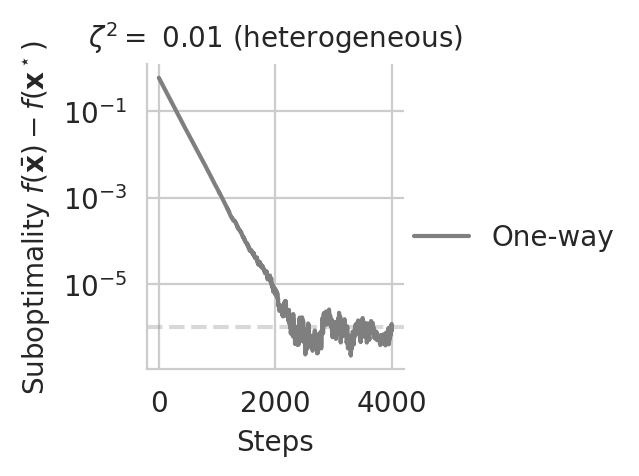

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Times"],
#     'text.latex.preamble' : r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{newtxmath}'
# })

colors = [sns.color_palette("tab10")[i] for i in [7, 0, 1, 9, 3]]
sns.set_palette(colors)

df = warehouse.query("error")
df["zeta2name"] = df["zeta2"].replace({0: "0 (equal optimum)", .01: "0.01 (heterogeneous)", 1: "1 (very heterogeneous)"})
df["algoname"] = df.algorithm.replace({"D2": r"$\text{D}^2$", "RelaySum/Model": "RelaySGD"})
import os
print(os.getcwd())
g = sns.FacetGrid(hue="algoname", col="zeta2name", data = df, height=2.5, sharex=False)
g.map(plt.plot, "step", "value")

for ax in g.axes[0]:
    ax.axhline(1e-6, ls='--', c='gray', alpha=0.3)

g.set_titles(r"$\zeta^2 =$ {col_name}")
g.set(yscale="log");
# g.set_ylabels(r"Mean sq. distance to optimum")
g.set_ylabels(r"Suboptimality $f(\bar{\mathbf{x}}) - f(\mathbf{x}^\star)$")
g.set(xlabel="Steps")
g.tight_layout()
# g.set(ylim=[1e-9, 1])
g.add_legend(title="")
plt.show(g)

In [ ]:
g.savefig("model_vs_grad_curves.pdf", bbox_inches="tight")

In [ ]:
num_workers = 32
d = 10
# noise = 0.5
noise = 0
mu = 0.5
zetas = [1]
max_steps = [4000]

# zetas = [0,  .01, 1]
# zetas = [1]
# max_steps = [200, 2000, 4000]
# max_steps = [3]

eval_intervals = [2, 5, 20]
plateau = 1e-6
seed = 0
warehouse = Warehouse()
algorithm_name = "One-way"
algorithm = one_way_path_averaging
topology = RingTopology(num_workers)
# topology = tree(num_workers)
eps = 1e-6
warehouse.clear("error", {"algorithm": algorithm_name})
for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    print("Task created")
    # if zeta2 == 0: 
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=700, num_test_points=1000) # 
    # steps, learning_rate = tuning.tune_fastest(start_lr=10, target_quality=eps, task=task, algorithm=algorithm, topology=topology, max_steps=200, num_test_points=1000)
    if learning_rate is not None: 
        print(f"The found learning rate = {learning_rate}")
    else: 
        learning_rate = 0.005
    
    print(f"Learning rate not found, using learning_rate = {learning_rate}")
    
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    print("warehouse.clear(\"error\", tags)")
    warehouse.clear("error", tags)
    errors = {}
    k = 0 
    print(f"Training started with steps {steps} and learning rate {learning_rate}")
    for iterate in algorithm(task, topology, learning_rate, num_steps, num_communication_rounds=2):
        # print(f"The step is at {iterate.step}")
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item()
            errors[iterate.step] = error
            if iterate.step % 100 == 0:
                print(f"The error at {iterate.step} is {error}")
            # if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-2:
            #     print("no improvement after", iterate.step)
            #     break
            if error < 1e-12:
                break
            # if k > 50:
            #     break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
        # print("Iteration ends")
        # if iterate.step > 50:
        #     break
    print(f"The error is {error}")

Tuning for 1
Task created
Learning rate not found, using learning_rate = 0.005
warehouse.clear("error", tags)
Training started with steps None and learning rate 0.005
The error at 0 is 0.592253522456097
The error at 100 is 0.32909448626190496
The error at 200 is 0.18389997195005225
The error at 300 is 0.10042811394637208
The error at 400 is 0.05787373475242852
The error at 500 is 0.033256836124416767
The error at 600 is 0.017971255289922494
The error at 700 is 0.009272741018254482
The error at 800 is 0.004661415083275333
The error at 900 is 0.002598430365424509
The error at 1000 is 0.0019038900625139021
The error at 1100 is 0.0009510686478446662
The error at 1200 is 0.0005723649885140958
The error at 1300 is 0.00028155512317962206
The error at 1400 is 0.0001961553289104856
The error at 1500 is 0.00011226876047221168
The error at 1600 is 9.292618239697958e-05
The error at 1700 is 8.1728828978056e-05
The error at 1800 is 7.665658772282313e-05
The error at 1900 is 5.46522329574195e-05
The

/home/ziwliu/relaysgd/paper-figures


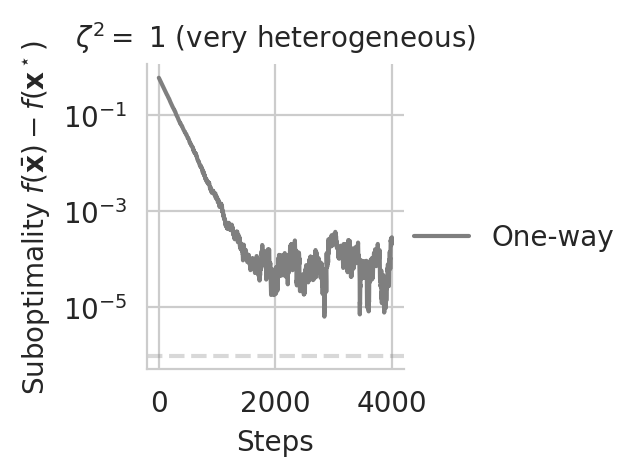

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Times"],
#     'text.latex.preamble' : r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{newtxmath}'
# })

colors = [sns.color_palette("tab10")[i] for i in [7, 0, 1, 9, 3]]
sns.set_palette(colors)

df = warehouse.query("error")
df["zeta2name"] = df["zeta2"].replace({0: "0 (equal optimum)", .01: "0.01 (heterogeneous)", 1: "1 (very heterogeneous)"})
df["algoname"] = df.algorithm.replace({"D2": r"$\text{D}^2$", "RelaySum/Model": "RelaySGD"})
import os
print(os.getcwd())
g = sns.FacetGrid(hue="algoname", col="zeta2name", data = df, height=2.5, sharex=False)
g.map(plt.plot, "step", "value")

for ax in g.axes[0]:
    ax.axhline(1e-6, ls='--', c='gray', alpha=0.3)

g.set_titles(r"$\zeta^2 =$ {col_name}")
g.set(yscale="log");
# g.set_ylabels(r"Mean sq. distance to optimum")
g.set_ylabels(r"Suboptimality $f(\bar{\mathbf{x}}) - f(\mathbf{x}^\star)$")
g.set(xlabel="Steps")
g.tight_layout()
# g.set(ylim=[1e-9, 1])
g.add_legend(title="")
plt.show(g)

In [ ]:
g.savefig("model_vs_grad_curves.pdf", bbox_inches="tight")

# All - Ring

## all

In [ ]:
num_workers = 32
d = 10
# noise = 0.5
noise = 0
mu = 0.5
zetas = [0, .01, 1]
max_steps = [200, 500, 2000]
eval_intervals = [2, 5, 20]
plateau = 1e-6
seed = 0
warehouse = Warehouse()
algorithm_name = "Gossip"
algorithm = gossip
topology_name = "ring"
topology = RingTopology(num_workers)
warehouse.clear("error", {"algorithm": algorithm_name})
for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000)
    print(f"learning rate is {learning_rate}")
    if learning_rate is None:
        continue
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    print("warehouse.clear(\"error\", tags)")
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
learning rate is 1.25
warehouse.clear("error", tags)
5.792939955034237e-13
Tuning for 0.01
learning rate is 0.0439453125
warehouse.clear("error", tags)
8.518613525757002e-07
Tuning for 1
learning rate is 0.0008392333984375
warehouse.clear("error", tags)
0.08293786081154209


In [ ]:
algorithm_name = "RelaySGD/OneNode"
algorithm = relaysgd
topology_name = "ring"
topology = RingTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000)
    if learning_rate is None:
        continue
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            # if error < 1e-12:
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
8.891940756770706e-13
Tuning for 0.01
6.231890004038121e-13
Tuning for 1
2.646771690706373e-13


In [ ]:
algorithm_name = "RelaySGD/Grad"
algorithm = relaysum_grad
topology_name = "ring"
topology = RingTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000)
    if learning_rate is None:
        continue
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
7.337735926384553e-11
Tuning for 0.01
2.0265183017786903e-08
Tuning for 1
8.653164309535555e-07


In [ ]:
algorithm_name = "RelaySGD"
algorithm = relaysum_model
topology_name = "ring"
topology = RingTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    eval_interval = 1
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_fastest(start_lr=10, target_quality=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=10000, num_test_points=1000)
    print(steps, learning_rate)
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

51 0.869140625
5.317038806265014e-10
51 0.869140625
9.848788451449764e-13
50 0.8837890625
9.592326932761353e-13


In [ ]:
algorithm_name = "SGP"
algorithm = time_varying_sgp
topology_name = "ring"
topology = RingTopology(num_workers)
eps = 1e-6
warehouse.clear("error", {"algorithm": algorithm_name})
for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    print("Task created")
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000) 
    # best_time, best_lr = tuning.tune_fastest(start_lr=10, target_quality=eps, task=task, algorithm=algorithm, topology=topology, max_steps=20000, num_test_points=1000)
    print(f"The found learning rate = {learning_rate}")

    if learning_rate is None:
        # continue
        steps = 50
        learning_rate = 0.5
        print("Learning rate not found, using learning_rate = {learning_rate}")
    
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    print("warehouse.clear(\"error\", tags)")
    warehouse.clear("error", tags)
    errors = {}
    k = 0 
    print(f"Training started with steps {steps} and learning rate {learning_rate}")
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        # print(f"The step is at {iterate.step}")
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item()
            errors[iterate.step] = error
            if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
                print("no improvement after", iterate.step)
                break
            if error < 1e-12:
                break
            if k > 50:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
        # print("Iteration ends")
        # if iterate.step > 50:
        #     break
    print(f"The error is {error}")

Tuning for 0
Task created
The found learning rate = 2.5
warehouse.clear("error", tags)
Training started with steps 29 and learning rate 2.5
no improvement after 42
The error is 3.5136987831112204e-12
Tuning for 0.01
Task created
The found learning rate = 0.234375
warehouse.clear("error", tags)
Training started with steps 64 and learning rate 0.234375
no improvement after 100
The error is 9.181585866758352e-07
Tuning for 1
Task created
The found learning rate = 0.01708984375
warehouse.clear("error", tags)
Training started with steps 889 and learning rate 0.01708984375
no improvement after 900
The error is 9.556455689008203e-07


## ompa

In [15]:
num_workers = 32
d = 10
# noise = 0.5
noise = 0
mu = 0.5
zetas = [0, .01 , 1]
max_steps = [200, 4000, 4000]
eval_intervals = [10, 500, 500]
plateau = 1e-6
seed = 0
num_communication_rounds = 16 
warehouse = Warehouse()
algorithm_name = "OWPA"
algorithm = one_way_path_averaging
topology_name = "ring"
topology = RingTopology(num_workers)
warehouse.clear("error", {"algorithm": algorithm_name})
for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    if zeta2 == 0: 
        tuning_steps = 1000
    else: 
        tuning_steps = 100
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=tuning_steps, num_test_points=1000)
    if learning_rate is None:
        if zeta2 == 0.01:
            learning_rate = 0.005 
        elif zeta2 == 1: 
            learning_rate = 0.005 
        print(f"didn't find a learning rate, using {learning_rate}")
    else:
        print(f"the found learning rate is {learning_rate}")
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    print("warehouse.clear(\"error\", tags)")
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
            print(f"The error is {error}")
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
the found learning rate is 2.5
warehouse.clear("error", tags)
The error is 0.592253522456097
The error is 1.312038690514804e-05
The error is 9.531799555228318e-10
The error is 1.884931113213617e-13
1.884931113213617e-13
Tuning for 0.01
didn't find a learning rate, using 0.005
warehouse.clear("error", tags)
The error is 0.592253522456097
The error is 0.03075705119922846
The error is 0.0016760303028011403
The error is 9.570829220357027e-05
The error is 5.967671510211103e-06
The error is 3.138995998616667e-07
The error is 2.673027945827855e-07
The error is 5.6850662438073796e-08
5.6850662438073796e-08
Tuning for 1
didn't find a learning rate, using 0.005
warehouse.clear("error", tags)
The error is 0.592253522456097
The error is 0.030401308481604383
The error is 0.0015094151444350334
The error is 0.0001375832259746801
The error is 1.9678194236538715e-05
The error is 3.47810742415966e-05
The error is 1.6416869695889957e-05
The error is 1.8490636997769982e-05
1.8490636997769982e

## plotting

/home/ziwliu/relaysgd/paper-figures
The learning rate is 0.005, the topology is ring


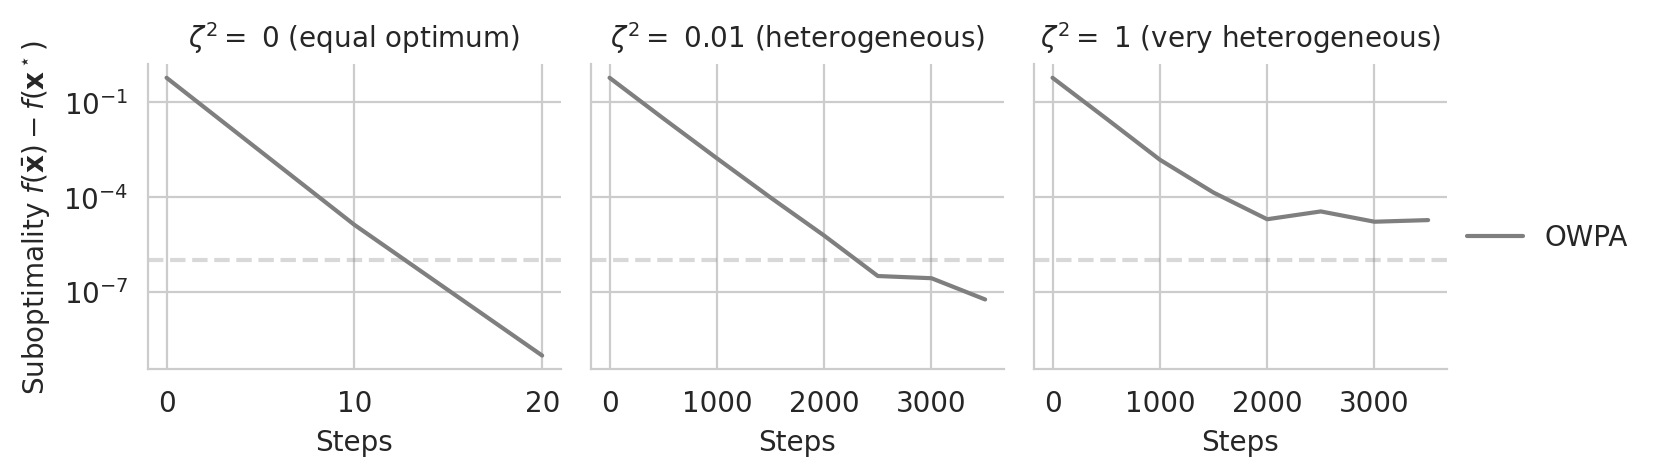

In [16]:
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
import matplotlib

colors = [sns.color_palette("tab10")[i] for i in [7, 0, 1, 9, 3]]
sns.set_palette(colors)

df = warehouse.query("error")
df["zeta2name"] = df["zeta2"].replace({0: "0 (equal optimum)", .01: "0.01 (heterogeneous)", 1: "1 (very heterogeneous)"})
df["algoname"] = df.algorithm.replace({"D2": r"$\text{D}^2$", "RelaySum/Model": "RelaySGD"})
import os
print(os.getcwd())
g = sns.FacetGrid(hue="algoname", col="zeta2name", data = df, height=2.5, sharex=False)
g.map(plt.plot, "step", "value")

for ax in g.axes[0]:
    ax.axhline(1e-6, ls='--', c='gray', alpha=0.3)

g.set_titles(r"$\zeta^2 =$ {col_name}")
g.set(yscale="log");
# g.set_ylabels(r"Mean sq. distance to optimum")
g.set_ylabels(r"Suboptimality $f(\bar{\mathbf{x}}) - f(\mathbf{x}^\star)$")
g.set(xlabel="Steps")
g.tight_layout()
# g.set(ylim=[1e-9, 1])
g.add_legend(title="")
print(f"The learning rate is {learning_rate}, the topology is {topology_name}")
plt.show(g)